In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'



In [2]:
# kaggle
# train_data_path = join("../input", "train.csv")
# sub_data_path = join("../input", "test.csv")

# local
train_data_path = join(".", "data", "train.csv")
sub_data_path = join(".", "data", "test.csv")


print(train_data_path)
print(sub_data_path)

.\data\train.csv
.\data\test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
<!-- 잘못된 설명으로 보임 -->
<!-- 20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음) -->
<!-- 21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음) -->
20.  sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21.  sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [3]:
################################
# 데이터 불러오기
################################

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

original_data = data.copy()

y = data["price"]
data = data.drop("price", axis=1)

# y = data["price"]
# del data['price']

train_len = len(data)
data = pd.concat((data, sub), axis=0)

data.head()

train data dim : (15035, 21)
sub data dim : (6468, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

# of missing id: 0
# of missing date: 0
# of missing bedrooms: 0
# of missing bathrooms: 0
# of missing sqft_living: 0
# of missing sqft_lot: 0
# of missing floors: 0
# of missing waterfront: 0
# of missing view: 0
# of missing condition: 0
# of missing grade: 0
# of missing sqft_above: 0
# of missing sqft_basement: 0
# of missing yr_built: 0
# of missing yr_renovated: 0
# of missing zipcode: 0
# of missing lat: 0
# of missing long: 0
# of missing sqft_living15: 0
# of missing sqft_lot15: 0


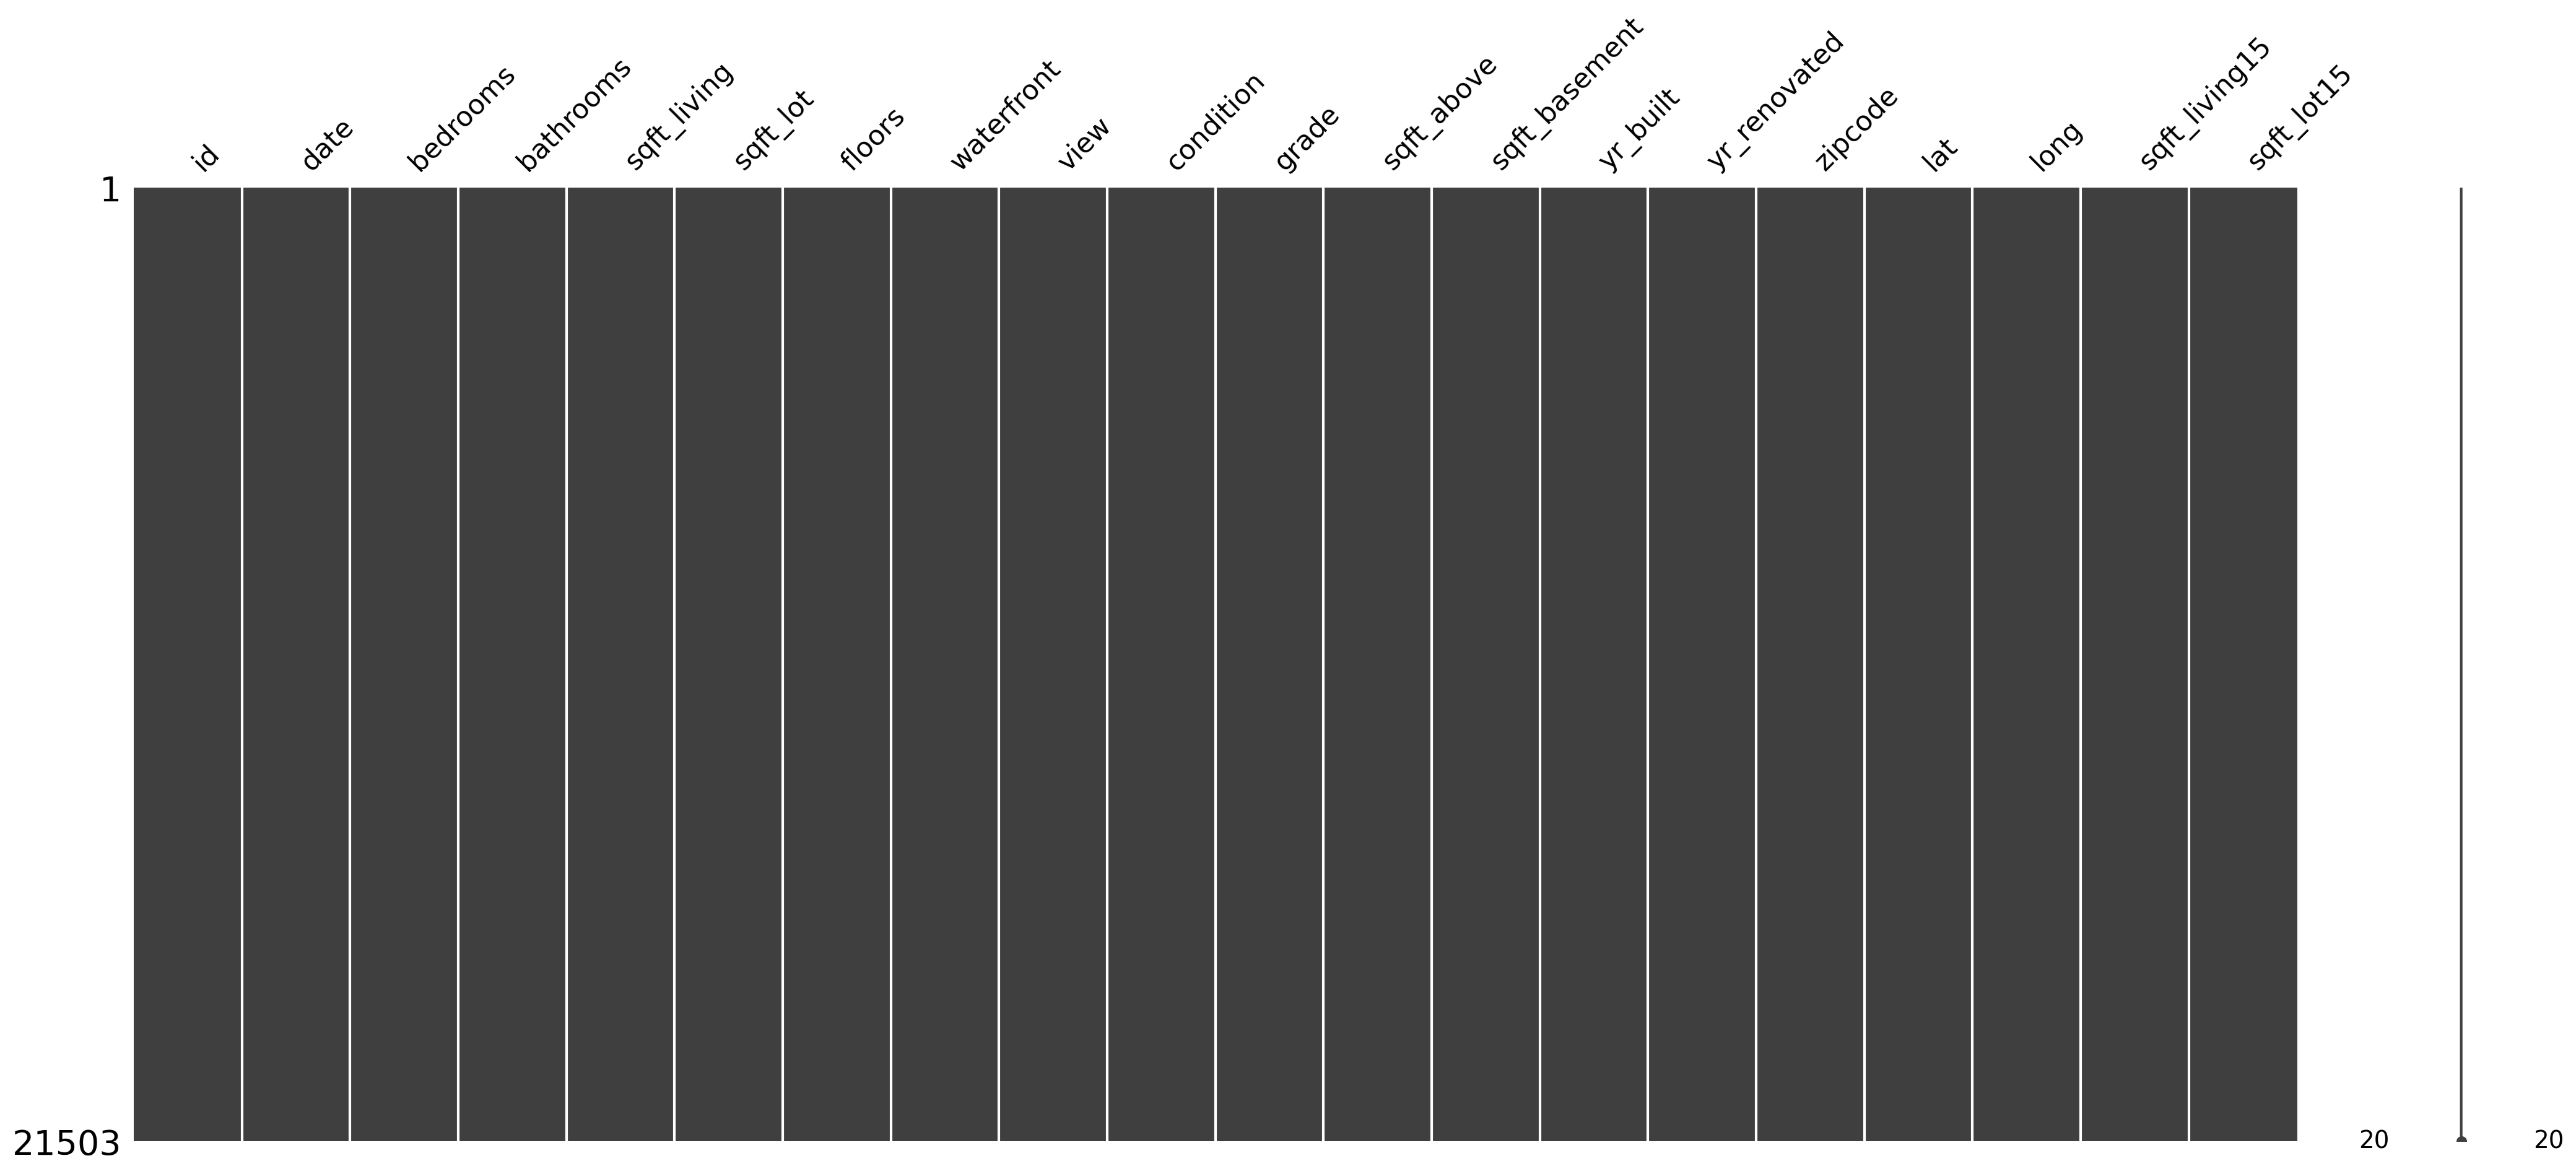

In [4]:
msno.matrix(data)


for col in data.columns:
    print("# of missing {}: {}".format(col, len(data.loc[pd.isnull(data[col]), col].values)))

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [5]:
# 예측결과 제출을 위해 저장 후 제거
sub_id = data['id'][train_len:]

# del data['id']
data = data.drop("id", axis=1)

# 20141013T000000 -> 201410
data["date"] = data["date"].apply(lambda x: str(x[:6])).astype(str)

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

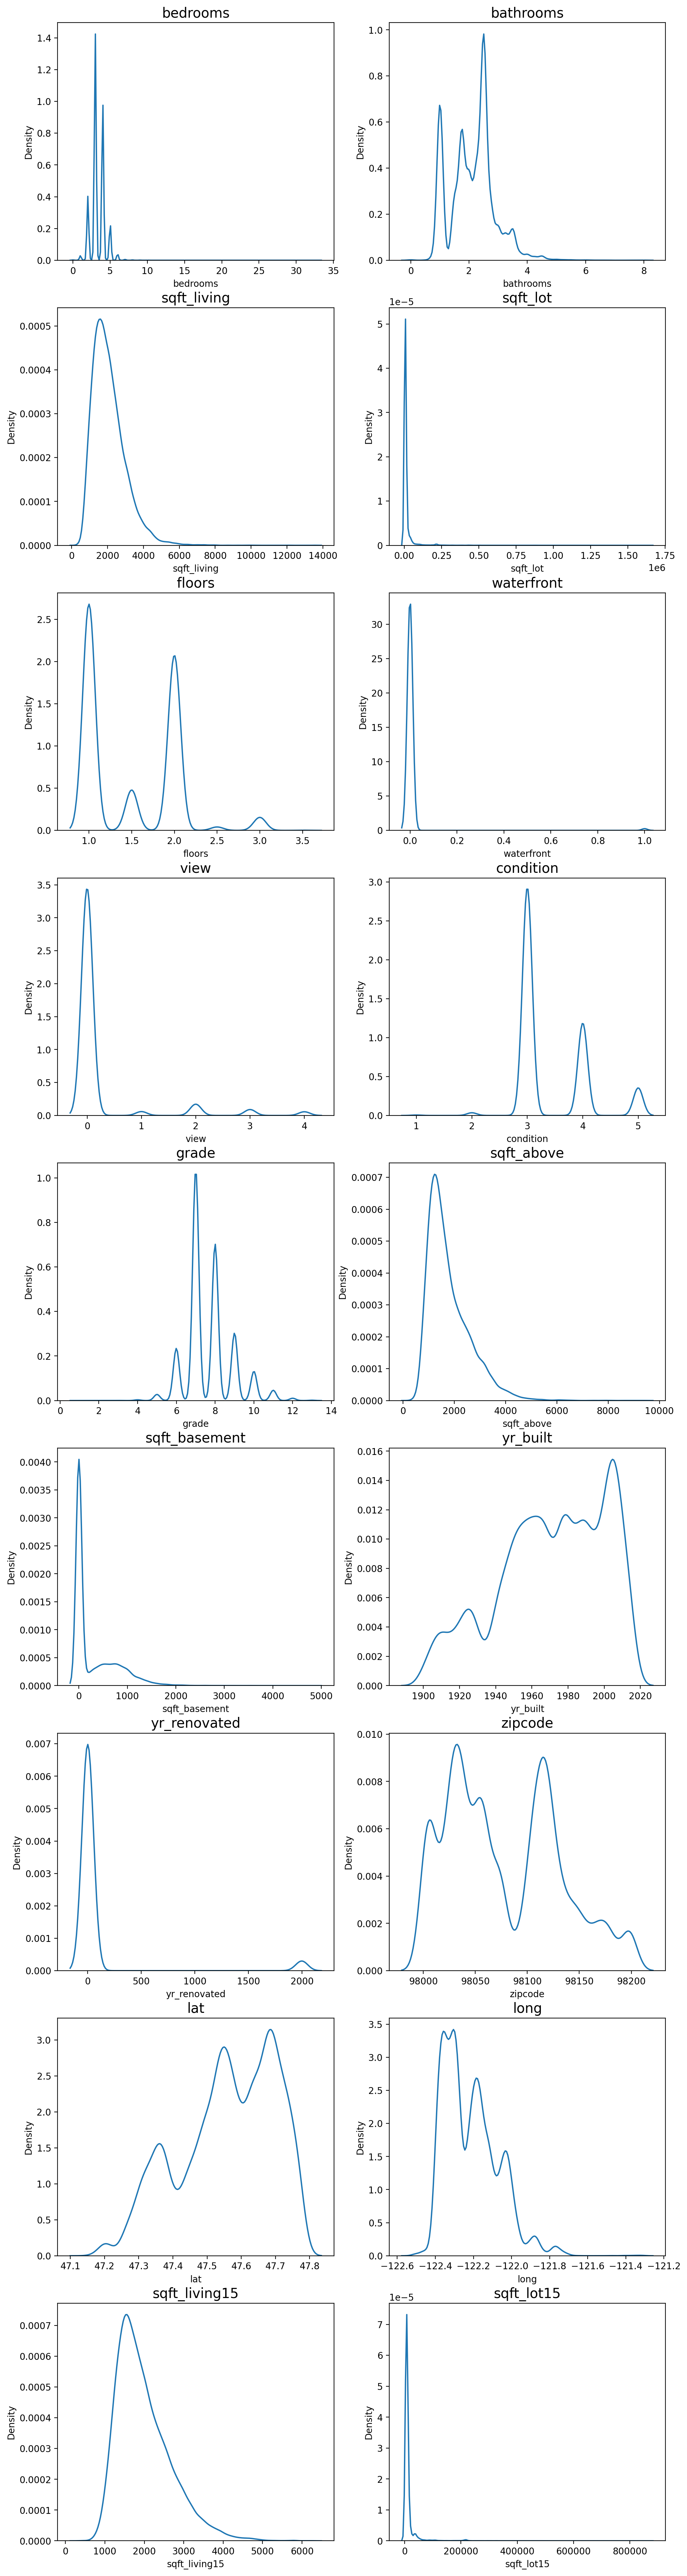

In [6]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))
# 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

`price`, `bedrooms`, `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement` 변수가 한쪽으로 치우친 경향을 보였습니다. log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [7]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for col in skew_columns:
    data[col] = np.log1p(data[col].values)

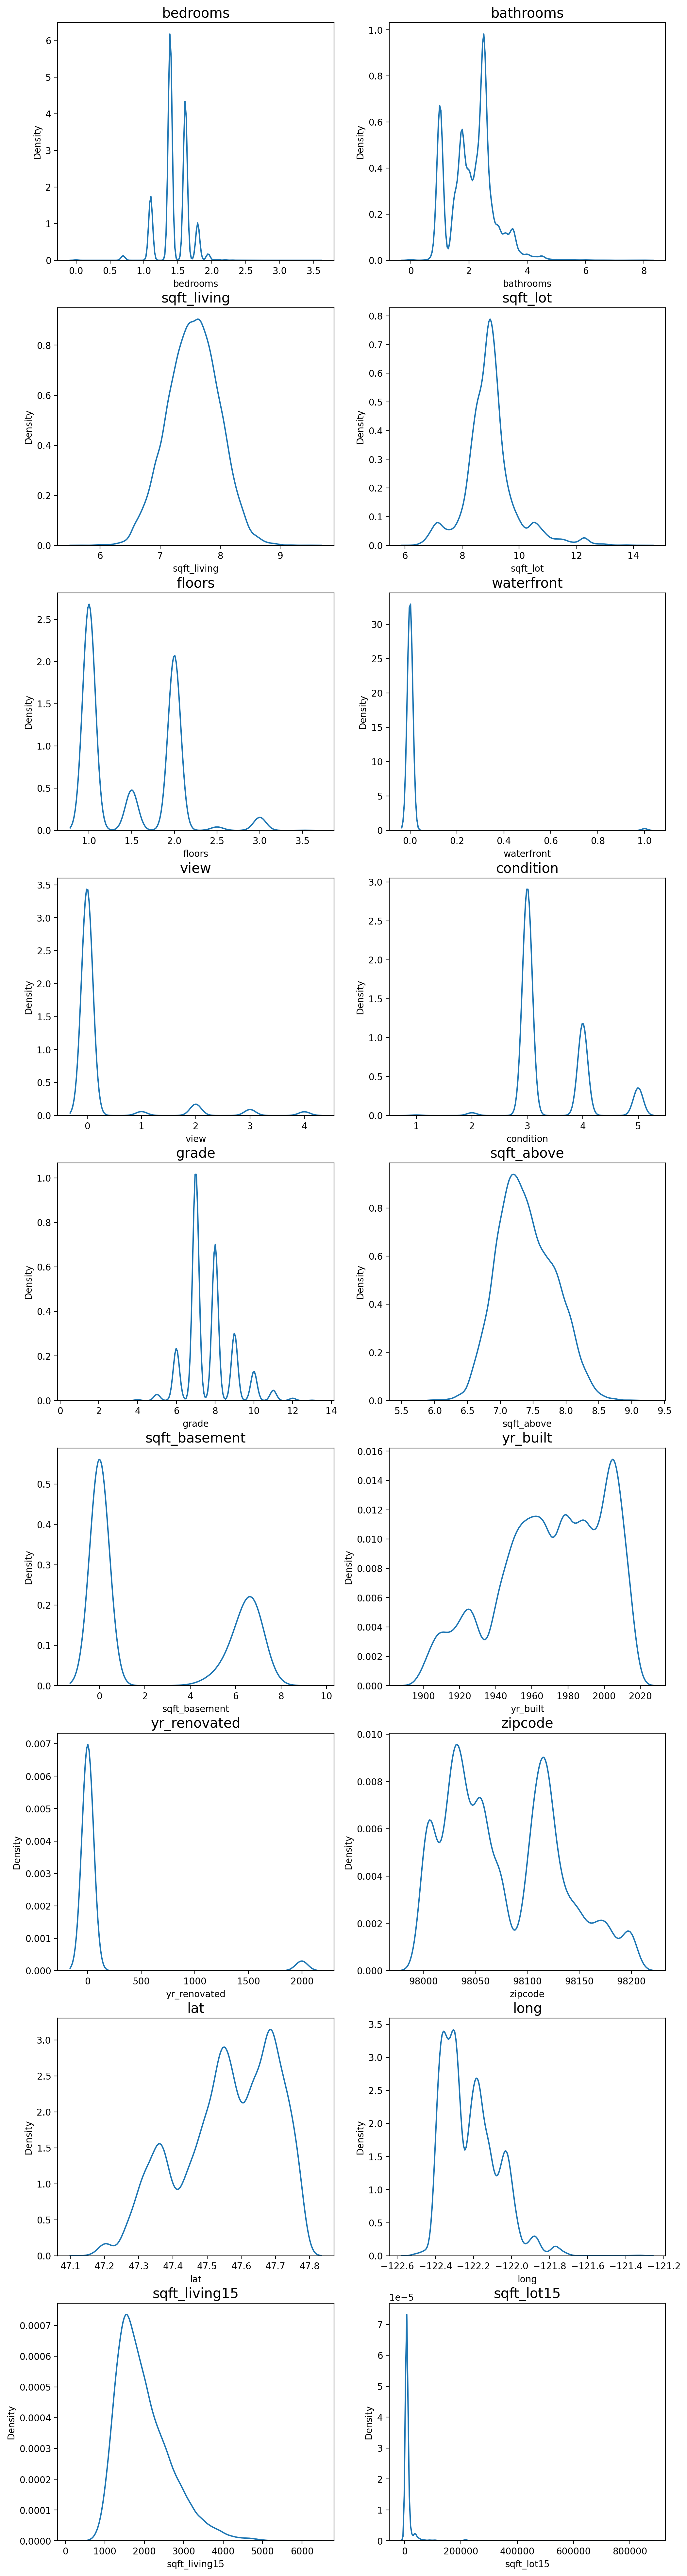

In [8]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))
# 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

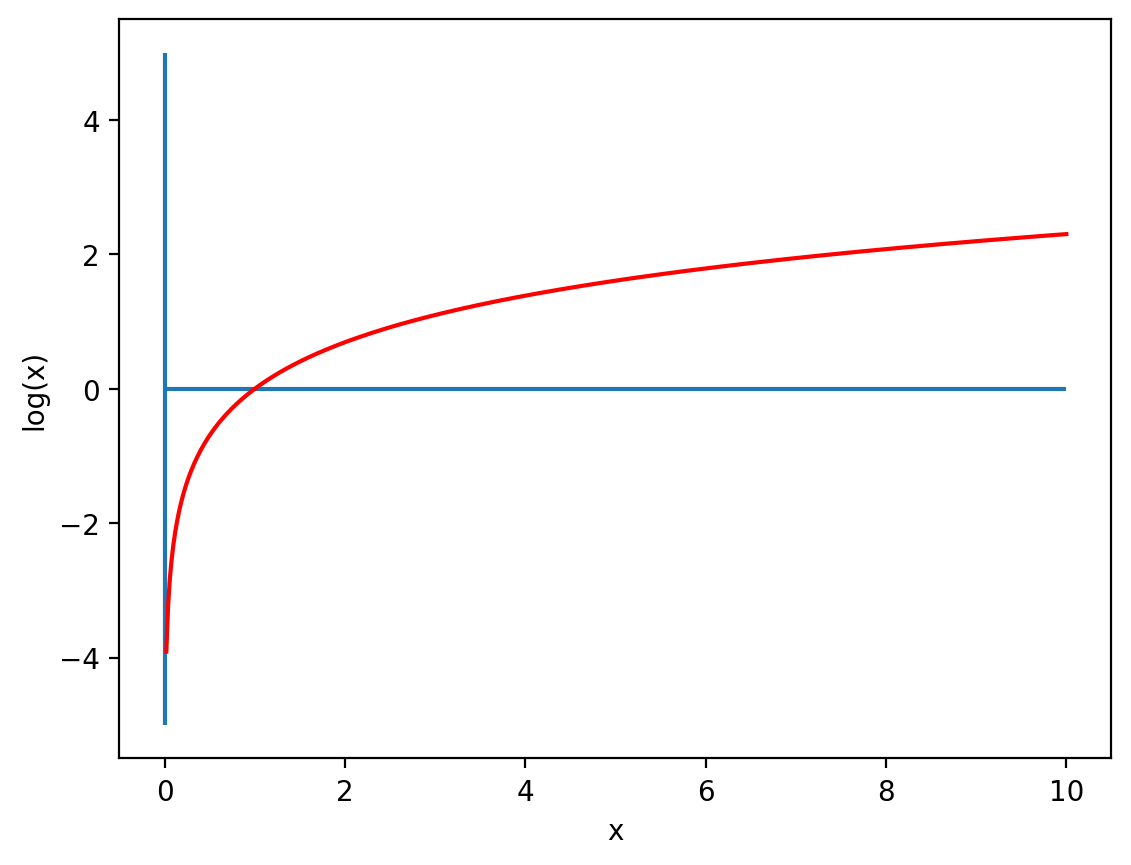

In [9]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c="r")
plt.xlabel("x")
plt.ylabel("log(x)")
plt.show()

In [10]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]


sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

x.head()

(15035, 19)
(6468, 19)


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,1650,9711


## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [11]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [
    {"model": gboost, "name": "GradientBoosting"},
    {"model": xgboost, "name": "XGBoost"},
    {"model": lightgbm, "name": "LightGBM"},
]

print("얍💢")

얍💢


### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [12]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m["model"], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")


print("얍💢")

get_cv_score(models)

얍💢


Model: GradientBoosting, CV score:0.8597
Model: XGBoost, CV score:0.8763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 540497.991270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 542956.681826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightG

### 결과
- Model: GradientBoosting, CV score:0.8597
- Model: XGBoost, CV score:0.8763
- Model: LightGBM, CV score:0.8819

결정계수 R squared https://ltlkodae.tistory.com/19


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [13]:
def AveragingBlending(models, x, y, sub_x):
    for m in models:
        m["model"].fit(x.values, y)

    predictions = np.column_stack([m["model"].predict(sub_x.values) for m in models])
    return np.mean(predictions, axis=1)


print("얍💢")

얍💢


In [14]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 540682.653143
6468


array([ 548944.53804912,  443655.17105951, 1345797.07909443, ...,
        457185.23303678,  339532.04977609,  422564.70651683])

In [15]:
sub = pd.DataFrame(data={"id": sub_id, "price": y_pred})
sub.head()
len(sub)

sub.to_csv("submission.csv", index=False)

# Restart (하이퍼파라미터 튜닝을 위해 다시 처음부터 시작해보기)


In [16]:
# data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
# train_data_path = join(data_dir, 'train.csv')
# test_data_path = join(data_dir, 'test.csv')


# local
train_data_path = join(".", "data", "train.csv")
test_data_path = join(".", "data", "test.csv")


print(train_data_path)
print(test_data_path)


train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)


train.head()

.\data\train.csv
.\data\test.csv


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [17]:
train.head()
train["date"] = train["date"].apply(lambda i: i[:6]).astype(int)

y = train["price"]
del train["price"]
del train["id"]

print(train.columns)
train.head()


## test 데이터에도 동일하게 적용
test.head()
test["date"] = test["date"].apply(lambda i: i[:6]).astype(int)
del test["id"]
print(test.columns)
test.head()

print(test.columns)

y.head()
# 값이 매우 크게나오고 narrow 분포임을 확인할 수 있음
print(y)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032

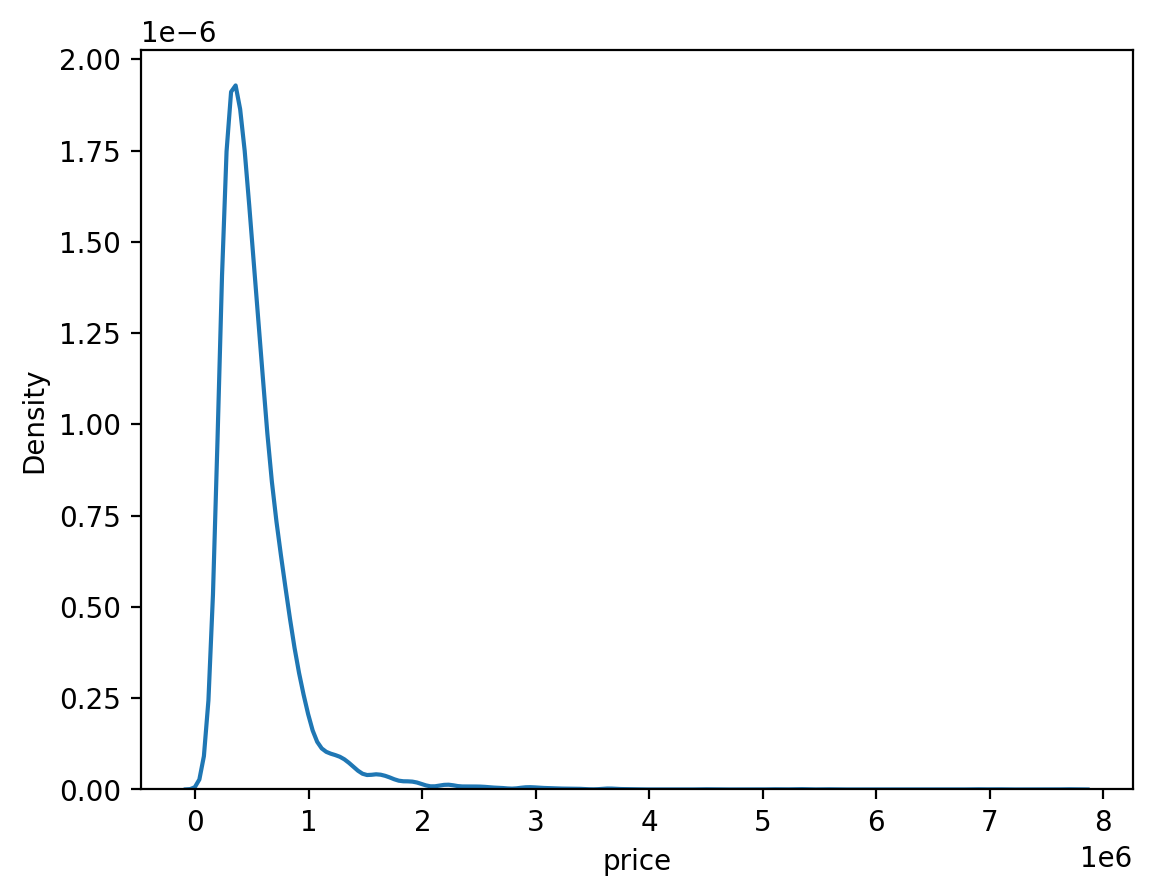

In [18]:
sns.kdeplot(y)
plt.show()

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64


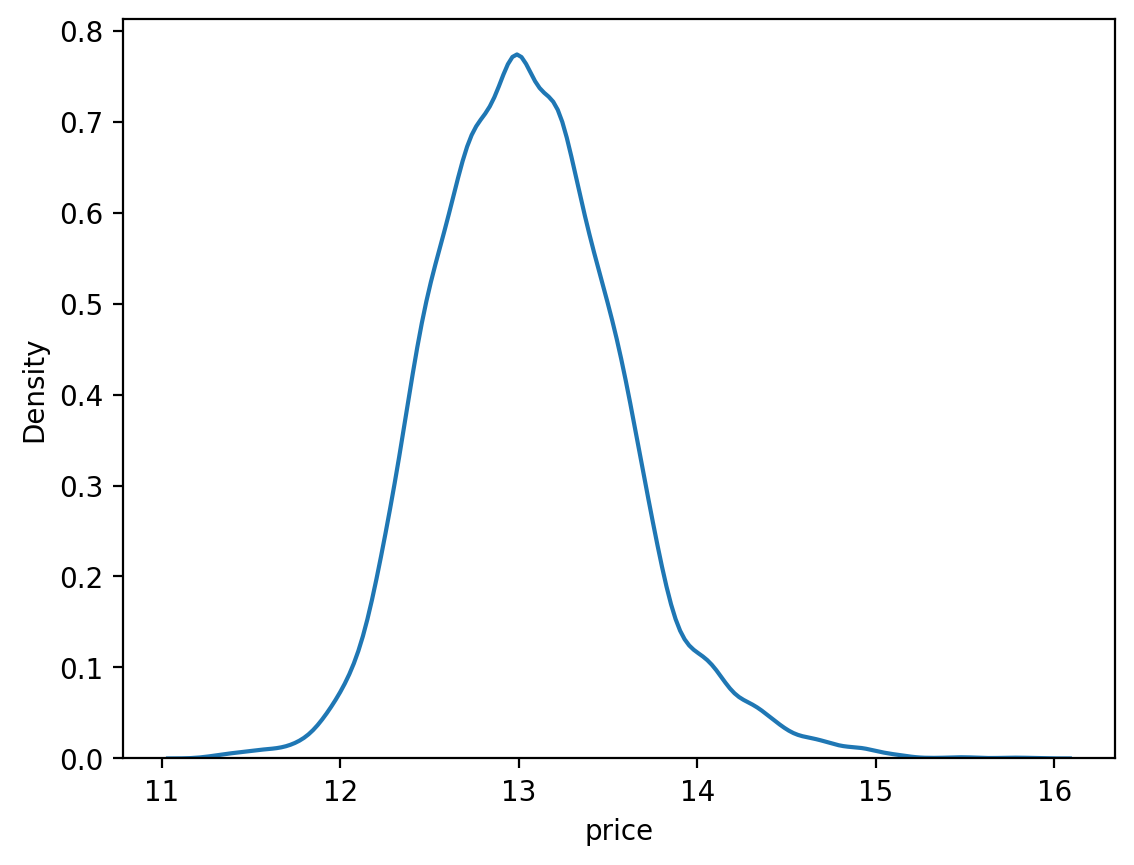

In [19]:
y = np.log1p(y)
print(y)
sns.kdeplot(y)
plt.show()

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int32  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           6468 non-null   int32  
 1   bedrooms       6468 non-null   int64  
 2   bathrooms      6468 non-null   float64
 3   sqft_living    6468 non-null   int64  
 4   sqft_lot       6468 non-null   int64  
 5   floors         6468 non-null   float64
 6   waterfront     6468 non-null   int64  
 7   view           6468 non-null   int64  
 8   condition      6468 non-null   int64  
 9   grade          6468 non-null   int64  
 10  sqft_above     6468 non-null   int64  
 11  sqft_basement  6468 non-null   int64  
 12  yr_built       6468 non-null   int64  
 13  yr_renovated   6468 non-null   int64  
 14  zipcode        6468 non-null   int64  
 15  lat            6468 non-null   float64
 16  long           6468 non-null   float64
 17  sqft_living15  6468 non-null   int64  
 18  sqft_lot

In [22]:
# RMSE 계산

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다.
# random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.
random_state = 2020  # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다.

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


print(gboost.__class__.__name__)
print(xgboost.__class__.__name__)
print(lightgbm.__class__.__name__)
print(rdforest.__class__.__name__)

GradientBoostingRegressor
XGBRegressor
LGBMRegressor
RandomForestRegressor


In [23]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
    # [[YOUR CODE]]
    X_train, X_test, y_train, y_test = train_test_split(
        train, y, test_size=0.2, random_state=42
    )

    # 모델 학습
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 RMSE 값 계산 및 저장
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    df[model_name] = rmse

    # data frame에 저장
    score_df = pd.DataFrame(df, index=["RMSE"]).T.sort_values("RMSE", ascending=True)
    print(score_df)


df

                               RMSE
GradientBoostingRegressor  0.185512
                               RMSE
XGBRegressor               0.175057
GradientBoostingRegressor  0.185512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047364
                               RMSE
LGBMRegressor              0.168297
XGBRegressor               0.175057
GradientBoostingRegressor  0.185512
                               RMSE
LGBMRegressor              0.168297
XGBRegressor               0.175057
RandomForestRegressor      0.181294
GradientBoostingRegressor  0.185512


{'GradientBoostingRegressor': 0.18551172945380454,
 'XGBRegressor': 0.175057277624652,
 'LGBMRegressor': 0.16829743100562075,
 'RandomForestRegressor': 0.18129413011152762}

In [24]:
def get_scores(models, X, y):
    # 결과 저장용 딕셔너리
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 RMSE 값 계산 및 저장
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        df[model_name] = rmse

    # 결과를 데이터프레임으로 저장 및 정렬
    score_df = pd.DataFrame(df, index=["RMSE"]).T.sort_values("RMSE", ascending=True)
    return score_df

get_scores(models, train, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047364


,RMSE
LGBMRegressor,0.168297
XGBRegressor,0.175057
RandomForestRegressor,0.181294
GradientBoostingRegressor,0.185512


### Hyperparameter tuning using `GridSearchCV`

In [25]:
from sklearn.model_selection import GridSearchCV

# param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
# scoring : 모델의 성능을 평가할 지표
# cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
# verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
# n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [1, 10],
}

model = LGBMRegressor(random_state=random_state)


# 다음과 같이 GridSearchCV를 이용해서 grid_model 모델을 초기화하고, train과 y 데이터로 모델을 간단히 학습시키면 param_grid 내의 모든 하이퍼 파라미터의 조합에 대해 실험이 완료됩니다.

# neg_mean_squared_error: 음수값을 가지는 MSE 값

grid_model = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1,
    n_jobs=5,
)

grid_model.fit(train, y)

grid_model.cv_results_

params = grid_model.cv_results_["params"]
print()
print()
print(params)

score = grid_model.cv_results_["mean_test_score"]
print(score)

results = pd.DataFrame(params)
# negative MSE로 계산된 score
results["score"] = score

results

# negative MSE 를 RMSE로 변환
results["RMSE"] = np.sqrt(-1 * results["score"])
results

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


[{'max_depth': 1, 'n_estimators': 50}, {'max_depth': 1, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 100}]
[-0.07339447 -0.05502043 -0.02917734 -0.02702714]


,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [26]:
results = results.rename(columns={"RMSE": "RMSLE"})
results

results = results.sort_values("RMSLE")
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [27]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""


# 코드 입력
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",
        cv=5,
        verbose=verbose,
        n_jobs=n_jobs,
    )

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_["params"]
    score = grid_model.cv_results_["mean_test_score"]

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results["score"] = score

    # RMSLE 값 계산 후 정렬
    results["RMSLE"] = np.sqrt(-1 * results["score"])
    results = results.sort_values("RMSLE")

    return results

In [34]:
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [1, 10],
}

# model = LGBMRegressor(random_state=random_state)
# 위 과정에서 score가 가장 높게 나온 하이퍼 파라미터를 사용: max_depth=10, n_estimators=100
max_depth = 10
n_estimators = 100
model = LGBMRegressor(
    max_depth=max_depth, n_estimators=n_estimators, random_state=random_state
)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

# --------------------------------
# --------------------------------
# --------------------------------
# --------------------------------

# model.fit(train, y)
# test.head()

# prediction = model.predict(test)
# prediction
# len(prediction)

# prediction = np.expm1(prediction)
# prediction

# # >> kaggle
# # data_dir = os.getenv("HOME") + "/aiffel/kaggle_kakr_housing/data"
# # >> local
# data_dir = join(".", "data")

# submission_path = join(data_dir, "sample_submission.csv")
# submission = pd.read_csv(submission_path)
# # submission.head()
# # 덮어씌우기
# submission["price"] = prediction
# # submission.head()
# # 저장하기
# submission_csv_path = "{}/submission_{}_RMSLE_{}.csv".format(
#     data_dir, "lgbm", "0.164399"
# )
# submission.to_csv(submission_csv_path, index=False)
# print(submission_csv_path)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [46]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_{model_name}_RMSLE_{rmsle}.csv` 형태의 `csv` 파일을 저장합니다.
"""

# 코드 작성


def save_submission(model, train, y, test, model_name, rmsle, submission_path):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    submission_path = join(data_dir, "sample_submission.csv")
    submission = pd.read_csv(submission_path)
    submission["price"] = prediction
    submission_csv_path = "{}/submission_{}_RMSLE_{}.csv".format(
        data_dir, model_name, rmsle
    )
    submission.to_csv(submission_csv_path, index=False)
    print("{} saved!".format(submission_csv_path))


# data_dir = os.getenv("HOME") + "/aiffel/kaggle_kakr_housing/data"
data_dir = join(".", "data")
save_submission(model, train, y, test, "lgbm", "0.164399", data_dir)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
.\data/submission_lgbm_RMSLE_0.164399.csv saved!


### 회고
- 